In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
import sklearn.metrics 


# Код из предоставленных материалов

In [42]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [43]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty  + l2_term)

In [44]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))     
    #---------------------------------
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))   
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1   
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #---------------------------------
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 
    
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.9, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

In [45]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

## Задание 1

### 1.1

In [46]:
N = 150

def make_binary_clf(N, noises, method = 'line',
                    random_state = 42):

    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) *noises
        out = (X, y)
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )

    
    return X,y

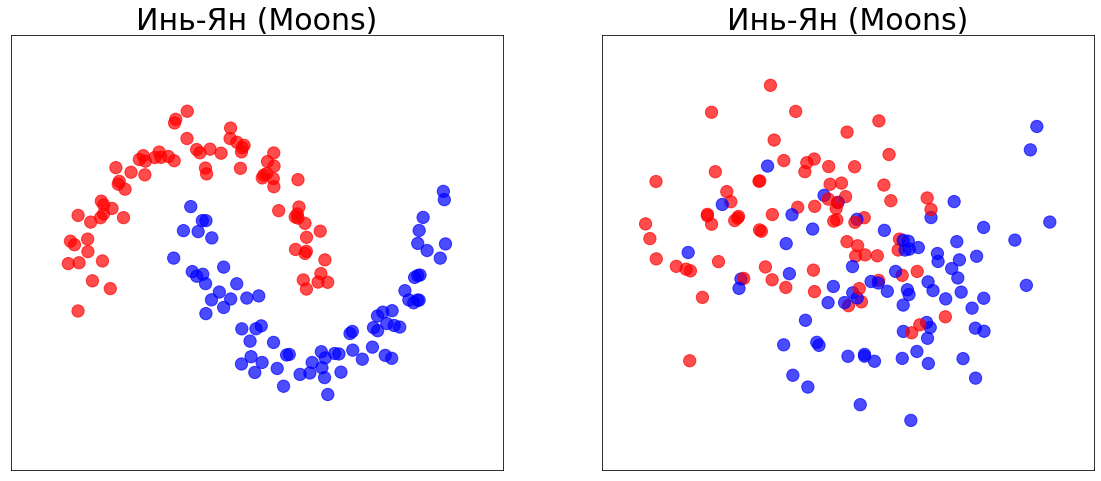

In [47]:

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,make_binary_clf(N,noises = 0.1,method = 'moons'), 
          'Инь-Ян (Moons)')

ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,noises = 0.5,method = 'moons'), 
          'Инь-Ян (Moons)')

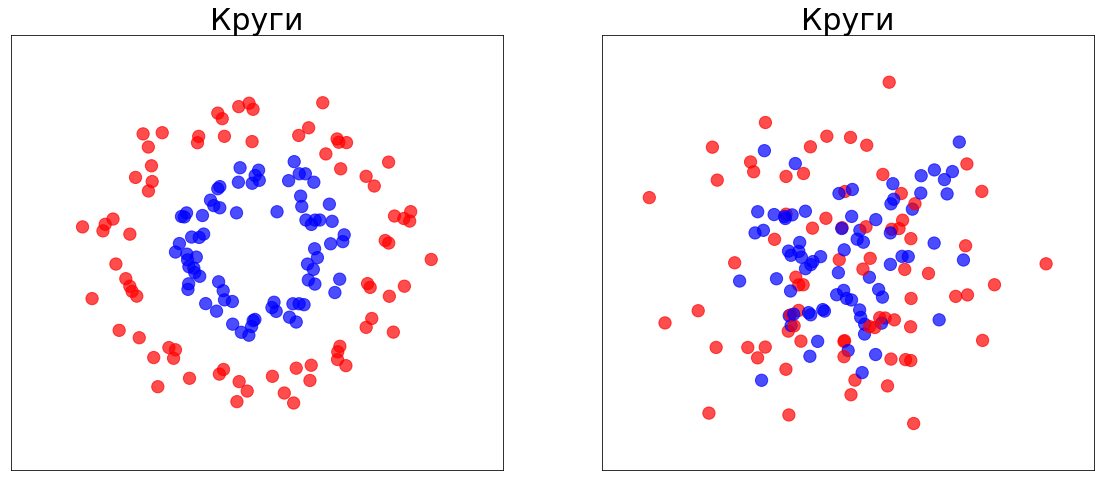

In [48]:

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,make_binary_clf(N,noises = 0.1,method = 'circles'), 
          'Круги')

ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,noises = 0.5,method = 'circles'), 
          'Круги')

### 1.2

In [49]:
def to_polynom(X, order = 5):
    order_range = range(order, order+1,1)
    out = np.copy(X) 
    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

In [50]:
X,y = make_binary_clf(N,noises = 0.5,method = 'circles')

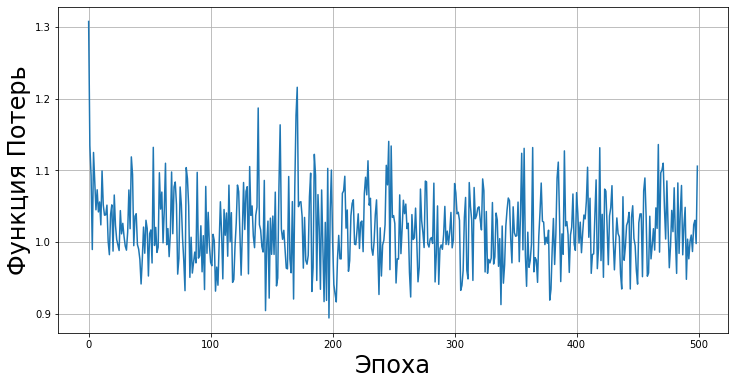

0.4666666666666667 0.5904761904761905
True Positives:0.4722	True Negatives:0.4444
False Positives:0.5278	False Negatives:0.5556
Accuracy:0.4667
Recall:0.7727	Precision:0.4722
f1 measure:0.5862


In [51]:
X_poly   = to_polynom(X, order = 3)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50)

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

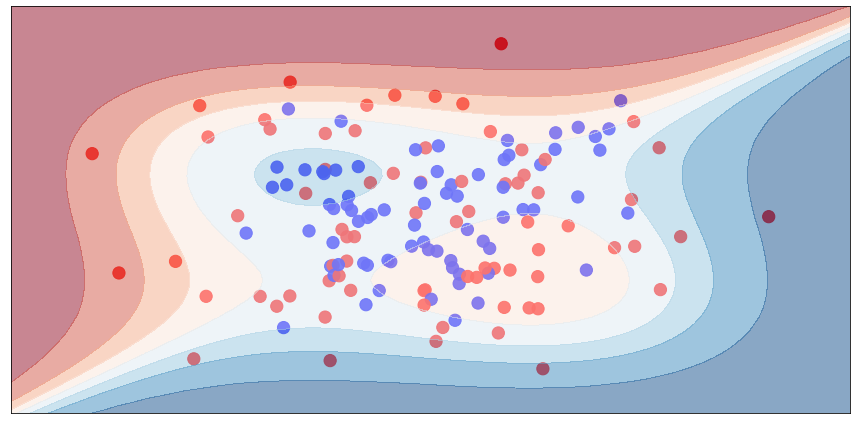

In [52]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 3)


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


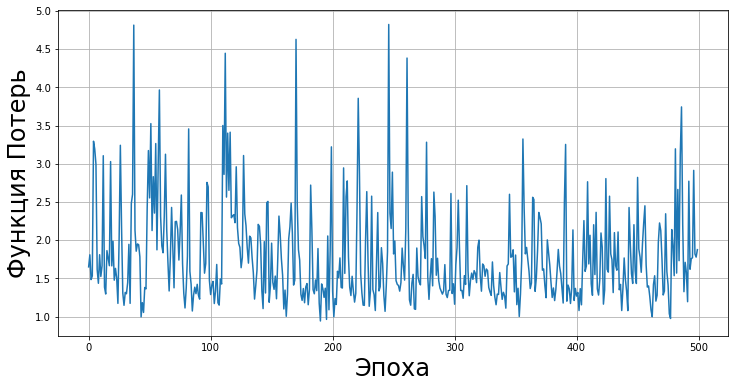

0.5333333333333333 0.6190476190476191
True Positives:0.5185	True Negatives:0.5556
False Positives:0.4815	False Negatives:0.4444
Accuracy:0.5333
Recall:0.6364	Precision:0.5185
f1 measure:0.5714


In [53]:
X_poly_7   = to_polynom(X, order = 7)

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_poly_7, y, test_size=0.3, random_state=42)

regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50)

regr.fit(X_train_7, y_train_7)

regr.plot_cost()

print(regr.score(X_test_7, y_test_7), regr.score(X_train_7, y_train_7))

regr.classification_report(X_test_7, y_test_7)

C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


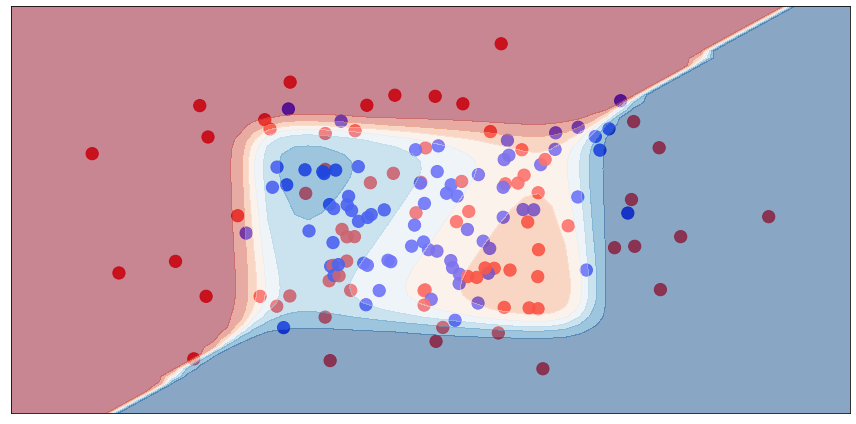

In [54]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 7)


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


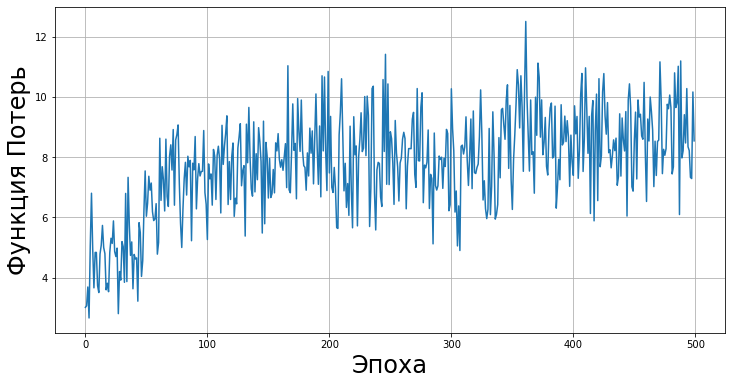

0.5333333333333333 0.5238095238095238
True Positives:0.5185	True Negatives:0.5556
False Positives:0.4815	False Negatives:0.4444
Accuracy:0.5333
Recall:0.6364	Precision:0.5185
f1 measure:0.5714


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [55]:
X_poly_15   = to_polynom(X, order = 15)

X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_poly_15, y, test_size=0.3, random_state=42)

regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50)

regr.fit(X_train_15, y_train_15)

regr.plot_cost()

print(regr.score(X_test_15, y_test_15), regr.score(X_train_15, y_train_15))

regr.classification_report(X_test_15, y_test_15)

C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


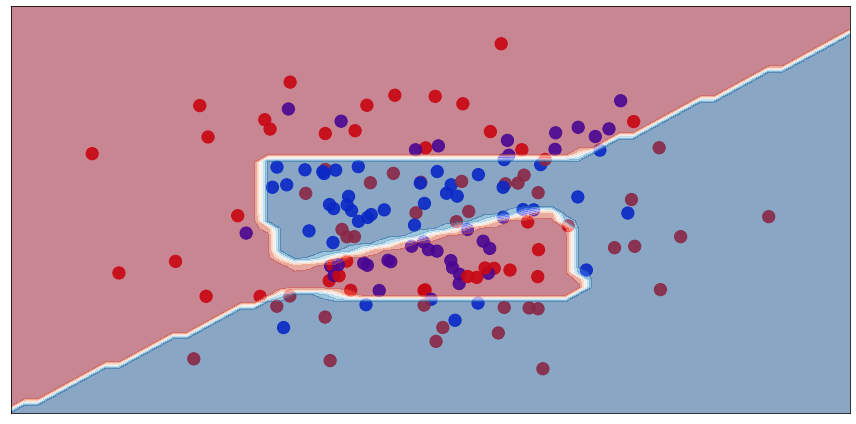

In [56]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 15)


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


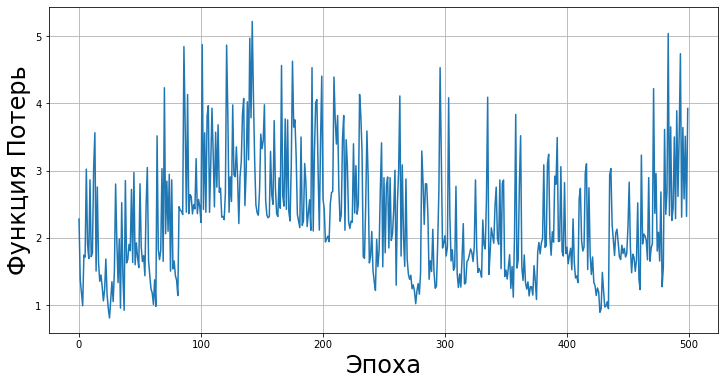

0.6444444444444445 0.6476190476190476
True Positives:0.6364	True Negatives:0.6522
False Positives:0.3636	False Negatives:0.3478
Accuracy:0.6444
Recall:0.6364	Precision:0.6364
f1 measure:0.6364


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [57]:
X_poly_10   = to_polynom(X, order = 10)

X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_poly_10, y, test_size=0.3, random_state=42)

regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50)

regr.fit(X_train_10, y_train_10)

regr.plot_cost()

print(regr.score(X_test_10, y_test_10), regr.score(X_train_10, y_train_10))

regr.classification_report(X_test_10, y_test_10)

C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


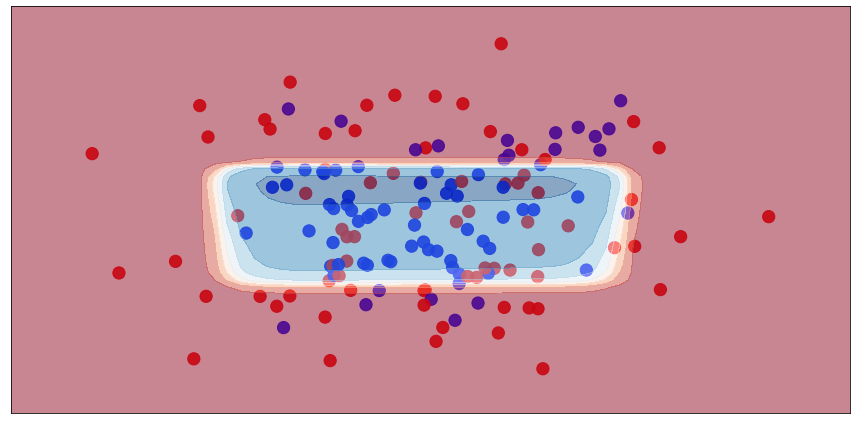

In [58]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 10)


### 1.3

In [59]:
print(f"Полином 7 {regr.score(X_test_7, y_test_7), regr.score(X_train_7, y_train_7)}")

regr.classification_report(X_test_7, y_test_7)

print('\n')

print(f"Полином 10 {regr.score(X_test_10, y_test_10), regr.score(X_train_10, y_train_10)}")

regr.classification_report(X_test_10, y_test_10)

print('\n')

print(f"Полином 15 {regr.score(X_test_15, y_test_15), regr.score(X_train_15, y_train_15)}")

regr.classification_report(X_test_15, y_test_15)


Полином 7 (0.4888888888888889, 0.5142857142857142)
True Positives:0.4839	True Negatives:0.5000
False Positives:0.5161	False Negatives:0.5000
Accuracy:0.4889
Recall:0.6818	Precision:0.4839
f1 measure:0.5660


Полином 10 (0.6444444444444445, 0.6476190476190476)
True Positives:0.6364	True Negatives:0.6522
False Positives:0.3636	False Negatives:0.3478
Accuracy:0.6444
Recall:0.6364	Precision:0.6364
f1 measure:0.6364


Полином 15 (0.5111111111111111, 0.580952380952381)
True Positives:0.5000	True Negatives:0.5385
False Positives:0.5000	False Negatives:0.4615
Accuracy:0.5111
Recall:0.7273	Precision:0.5000
f1 measure:0.5926


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Полином 10 имеет лучше показания по всем метрикам по сравнению с Полиномом 15, кроме Recall. Полином 15 больше определяет синих как синих и красных как красных. Если бы необходима была бы большая точность и цена ошибки определения класса была бы высока, то стоило бы применять Полином 15. Однако в среднем предположу, что Полином 10 более эффективен о чем говорит сравнение всех метрик, а также что среднее гармоническое между Recall и Precision - f1 measure выше у Полинома 10. 

## Задание 2

In [60]:
data = pd.read_csv('new_columns.csv')
data = data.drop(['Unnamed: 0','Engine_Type'],axis=1)
data.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Price_per_distance
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727,со средним пробегом,0.039744
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000,со средним пробегом,0.063333
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000,со средним пробегом,0.059545
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000,со средним пробегом,0.020500
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636,со средним пробегом,0.011633


In [61]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year','Price_per_distance']

In [62]:
X = data[num_columns]
y = data['Transmission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


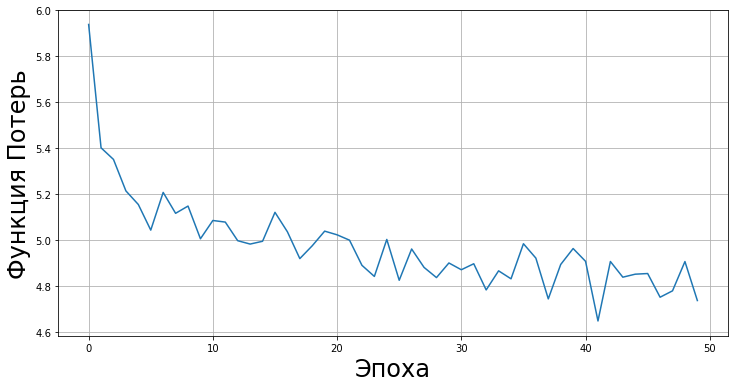

0.7430167597765364 0.7444237533623008
True Positives:0.7904	True Negatives:0.7194
False Positives:0.2096	False Negatives:0.2806
Accuracy:0.7430
Recall:0.5837	Precision:0.7904
f1 measure:0.6715


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [63]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=50,batch_size=100,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Модель довольно хорошо справляется. Лучше чем угадайка.

# Оценим влияние предварительной обработки

## Логарифм

In [66]:
data = pd.read_csv('after_log.csv')
data = data.drop('Unnamed: 0',axis=1)
data.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Price_per_distance
0,Toyota,Prius,7.606387,Hatchback,12.180755,7.495542,Hybrid,1,8.955448,11,17727.272727,со средним пробегом,0.039744
1,Renault,Grand Scenic,7.607878,Universal,11.813030,7.313220,Diesel,0,9.053687,8,16875.000000,со средним пробегом,0.063333
2,Renault,Laguna,7.606885,Universal,11.608236,7.313220,Diesel,0,8.787220,10,11000.000000,со средним пробегом,0.059545
3,Opel,Astra,7.603898,Universal,12.206073,7.377759,Metan/Propan,0,8.318742,16,12500.000000,со средним пробегом,0.020500
4,Mercedes,Vito,7.600902,Microvan,12.611538,7.696213,Diesel,0,8.157657,22,13636.363636,со средним пробегом,0.011633


In [67]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year','Price_per_distance']

In [68]:
X = data[num_columns]
y = data['Transmission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


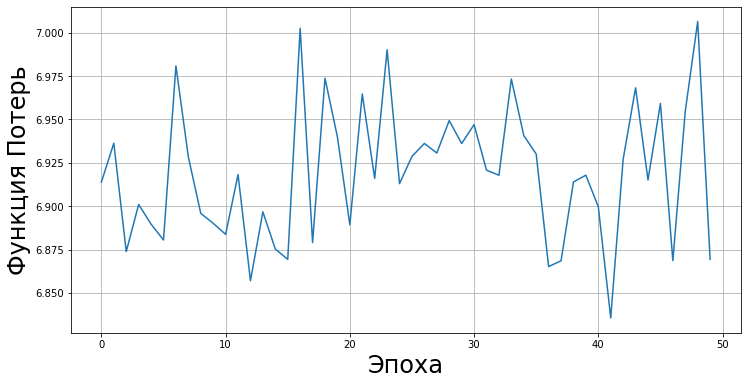

0.46517690875232776 0.4532588454376164
True Positives:0.4652	True Negatives:nan
False Positives:0.5348	False Negatives:nan
Accuracy:0.4652
Recall:1.0000	Precision:0.4652
f1 measure:0.6350


C:\Temp\ipykernel_4180\3898968993.py:103: RuntimeWarning: invalid value encountered in long_scalars
  print('True Negatives:%.4f'%(tn/n))
C:\Temp\ipykernel_4180\3898968993.py:105: RuntimeWarning: invalid value encountered in long_scalars
  print('False Negatives:%.4f'%(fn/n))


In [69]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=50,batch_size=100,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

## Стандартизация

In [70]:
data = pd.read_csv('after_standartization.csv')
data = data.drop('Unnamed: 0',axis=1)
data.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Price_per_distance
0,Toyota,Prius,0.376492,Hatchback,0.128983,-0.112516,Hybrid,1,-0.179081,11,17727.272727,со средним пробегом,0.039744
1,Renault,Grand Scenic,0.793761,Universal,-0.490816,-0.604496,Diesel,0,-0.095044,8,16875.000000,со средним пробегом,0.063333
2,Renault,Laguna,0.515582,Universal,-0.749065,-0.604496,Diesel,0,-0.305136,10,11000.000000,со средним пробегом,0.059545
3,Opel,Astra,-0.318957,Universal,0.180633,-0.440503,Metan/Propan,0,-0.562500,16,12500.000000,со средним пробегом,0.020500
4,Mercedes,Vito,-1.153495,Microvan,1.213632,0.543457,Diesel,0,-0.626578,22,13636.363636,со средним пробегом,0.011633


In [71]:
X = data[num_columns]
y = data['Transmission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


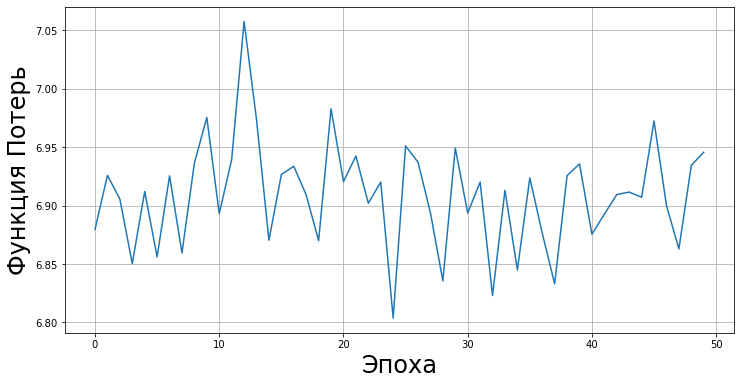

0.46517690875232776 0.4532588454376164
True Positives:0.4652	True Negatives:nan
False Positives:0.5348	False Negatives:nan
Accuracy:0.4652
Recall:1.0000	Precision:0.4652
f1 measure:0.6350


C:\Temp\ipykernel_4180\3898968993.py:103: RuntimeWarning: invalid value encountered in long_scalars
  print('True Negatives:%.4f'%(tn/n))
C:\Temp\ipykernel_4180\3898968993.py:105: RuntimeWarning: invalid value encountered in long_scalars
  print('False Negatives:%.4f'%(fn/n))


In [72]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=50,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

## Нормализация

In [73]:
data = pd.read_csv('after_normalization.csv')
data = data.drop('Unnamed: 0',axis=1)
data.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Price_per_distance
0,Toyota,Prius,0.80,Hatchback,0.194919,0.333333,Hybrid,1,0.075651,11,17727.272727,со средним пробегом,0.039744
1,Renault,Grand Scenic,0.86,Universal,0.134913,0.270833,Diesel,0,0.083667,8,16875.000000,со средним пробегом,0.063333
2,Renault,Laguna,0.82,Universal,0.109911,0.270833,Diesel,0,0.063627,10,11000.000000,со средним пробегом,0.059545
3,Opel,Astra,0.70,Universal,0.199920,0.291667,Metan/Propan,0,0.039078,16,12500.000000,со средним пробегом,0.020500
4,Mercedes,Vito,0.58,Microvan,0.299930,0.416667,Diesel,0,0.032966,22,13636.363636,со средним пробегом,0.011633


In [74]:
X = data[num_columns]
y = data['Transmission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


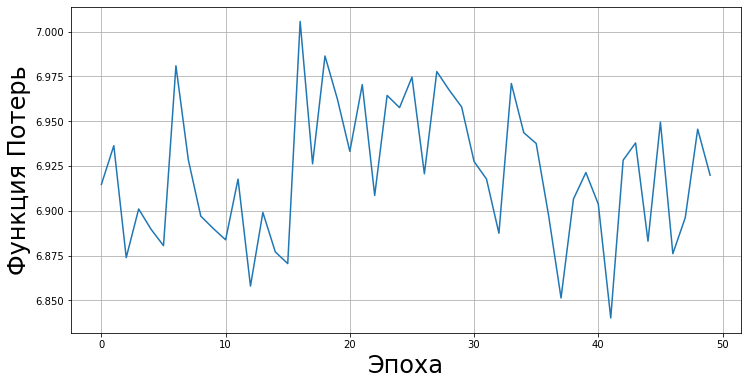

0.46517690875232776 0.4532588454376164
True Positives:0.4652	True Negatives:nan
False Positives:0.5348	False Negatives:nan
Accuracy:0.4652
Recall:1.0000	Precision:0.4652
f1 measure:0.6350


C:\Temp\ipykernel_4180\3898968993.py:103: RuntimeWarning: invalid value encountered in long_scalars
  print('True Negatives:%.4f'%(tn/n))
C:\Temp\ipykernel_4180\3898968993.py:105: RuntimeWarning: invalid value encountered in long_scalars
  print('False Negatives:%.4f'%(fn/n))


In [75]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=50,batch_size=100,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

## One-Hot

In [99]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year','Price_per_distance','Low','High','Medium']

In [100]:
data = pd.read_csv('before_ordinal_encoding.csv', delimiter = ',')
data.head()

,Unnamed: 0,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Price_per_distance,Engine_Type
0,0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727,со средним пробегом,0.039744,Meduim
1,1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000,со средним пробегом,0.063333,Low
2,2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000,со средним пробегом,0.059545,Low
3,3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000,со средним пробегом,0.020500,Meduim
4,4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636,со средним пробегом,0.011633,High


In [101]:
dd = data.copy()

In [102]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(data[['Engine_Type']])
dd = dd.assign(High = [i[0] for i in ohe.fit_transform(data[['Engine_Type']])], Low = [i[1] for i in ohe.fit_transform(data[['Engine_Type']])],
              Medium = [i[2] for i in ohe.fit_transform(data[['Engine_Type']])])
dd

,Unnamed: 0,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Price_per_distance,Engine_Type,High,Low,Medium
0,0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727,со средним пробегом,0.039744,Meduim,0.0,0.0,1.0
1,1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000,со средним пробегом,0.063333,Low,0.0,1.0,0.0
2,2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000,со средним пробегом,0.059545,Low,0.0,1.0,0.0
3,3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000,со средним пробегом,0.020500,Meduim,0.0,0.0,1.0
4,4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636,со средним пробегом,0.011633,High,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,1,11500.0,6,14666.666667,со средним пробегом,0.130682,Meduim,0.0,0.0,1.0
32216,32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,0,4400.0,20,11250.000000,со средним пробегом,0.019556,Meduim,0.0,0.0,1.0
32217,32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,0,7000.0,7,12714.285714,со средним пробегом,0.078652,Low,0.0,1.0,0.0
32218,32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,0,4000.0,16,23125.000000,с большим пробегом,0.010811,High,1.0,0.0,0.0


In [105]:
X = dd[num_columns]
y = dd['Transmission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


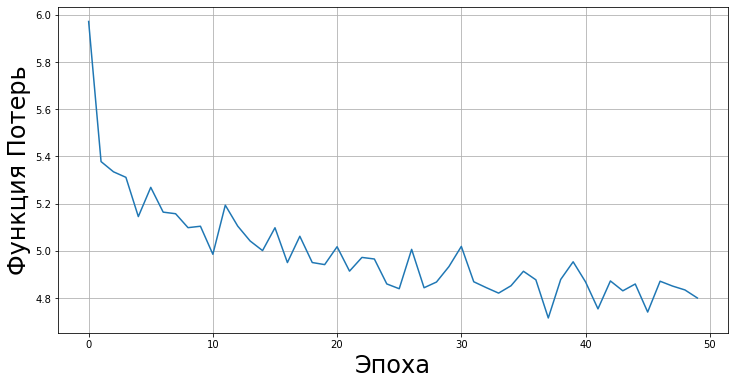

0.7390440720049659 0.7487688806124561
True Positives:0.7926	True Negatives:0.7103
False Positives:0.2074	False Negatives:0.2897
Accuracy:0.7390
Recall:0.5946	Precision:0.7926
f1 measure:0.6795


C:\Temp\ipykernel_4180\3898968993.py:37: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [106]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=50,batch_size=100,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

# Вывод

Новый придуманный признак мало повлиял на точность модели. Что удивительно каждая из предобработок моделей снизили точность согласно Accuracy метрике. В остальных метриках - precision,f1-score также заметно снижение качества предсказаний. после стандартизации и нормализации recall стал равен единице, что значит мы находим все данные. Однако precision 0.46, что значит половина из выбранных данных не нужна. Вполне вероятно, что каждую модель можно применять для своих случаев и там где необходимо неупустить не одного представителя выбранного класса, то recall 1 хорошее значение. Хоть и подозрительное.

In [80]:
from sklearn import LogisticRegression
logreg = LogisticRegression(random_state=16)


logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

ImportError: cannot import name 'LogisticRegression' from 'sklearn' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\__init__.py)

In [ ]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()